In [ ]:
!pip install wand
!apt install imagemagick
!pip install myqlm
!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 KB 6.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texliv

In [ ]:
import os
os.kill(os.getpid(), 9)

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [ ]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
  b = np.binary_repr(x, width=nqubits)
  b = [int(b[i]) for i in range(nqubits)]
  # TODO: Complete the computation below:
  val = 0
  for (s1, s2) in edges:
    val += (2*b[s1]-1)*(2*b[s2]-1)
  # END TODO
  if val <= best_value:
      best_value = val
      best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

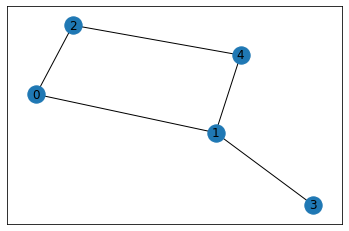

In [ ]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [ ]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [ ]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3
One can see that $U_{ZZ}(\beta)$ only changes the phase of the state. The phase becomes $e^{-i\beta /2}$ if the qubits are equal and $e^{+i\beta /2}$ when they are different. It can be shown that $e^{-i\beta H_c} = U_{ZZ}(2\beta)$. Indeed:
$$e^{-i\beta H_c} = e^{-\beta \sum_{i,j \in E} \sigma_i \sigma_j} = \prod_{i,j \in E} e^{-i\beta \sigma_i \sigma_j}$$
Using $\langle 1 |\sigma |1 \rangle = 1$ and $\langle 0 |\sigma |0 \rangle = - 1$ (as defined in the instructions), we find:


*   $\langle x_i x_j |e^{-i\beta \sigma_i \sigma_j} |x_i x_j \rangle= e^{-i\beta}$ when the qubits are equal ($x_i = x_j$).
*   $\langle x_i x_j |e^{-i\beta \sigma_i \sigma_j} |x_i x_j \rangle= e^{+i\beta}$ when the qubits are opposite ($x_i = -x_j$).

Which proves the result.


In [ ]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer

    # Layer of rotations RX(theta)
    for qubit in range(n_qubits):
      layer.apply(RX(theta), qubit)

    # Layer of exp(-i beta H_C)
    for (qubit1, qubit2) in edges:
      layer.apply(U_ZZ(2*beta), qubit1, qubit2)
    return layer

### Question 4

In [ ]:
from qat.qpus import get_default_qpu
import cmath
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    # Hadamard tower
    for qubit in qubits:
      prog.apply(H, qubit)
    
    # parameterized circuit
    num_iterations = len(parameters)//2
    for i in range(num_iterations):
      theta, beta = parameters[2*i], parameters[2*i+1]
      prog.apply(one_qaoa_layer(n_qubits, edges, theta, beta), qubits)
    
        
    # END TODO
    circ = prog.to_circ()

    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
      # this loop is over all 2**nqubits states.
      # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
      b = [int(i)*2-1 for i in sample.state.bitstring] # transforme les 0 en -1 sans modifier les 1.
      for i,j in edges:
        obs += b[i]*b[j]*sample.probability
    # END TODO
    return obs

In [ ]:
import numpy as np
np.random.random(3)

array([0.80149158, 0.02008969, 0.85893368])

In [ ]:
from scipy.optimize import minimize

### Random initialisation

### Question 5: 
réponse à la question:

-0.9010700029857371 -1.475038574037623 -1.7494599463092821 -2.2268784162630006 -2.3868245228819154 -2.5489655908684212 -2.649677766474337 -2.8033800530154966 -3.005881799332269 -3.138135925548933 -3.326530890992737 -3.4876664417536474 -3.5649678171023758 -3.5919246229798554 -3.594650098631919 -3.5957285972710653 -3.595745574867204 -3.5957470259365834 -3.595747093065027 -3.595747218025207 -3.5957474576183066 -3.5957494716252034 -3.595766462027333 -3.595782721842763 -3.595811052826924 -3.5971086391765112 -3.5975235261371985 -3.59825466070448 -3.5993034737512786 -3.599863017471446 -3.6002015882477925 -3.6008011044419383 -3.6011983061358634 -3.601732681401302 -3.6020897821138043 -3.602386739772238 -3.602683316141488 -3.602843328938349 -3.602894714606002 -3.6029172490309 -3.602918348435481 -3.602918354278881 -3.6029183547061674 -3.6029183547252344 -0.4327459144885901 -1.1763035008229454 -1.4453112655960112 -1.6480467865716142 -1.9303169294682585 -2.093002819382598 -2.330304728332389 -2.7098

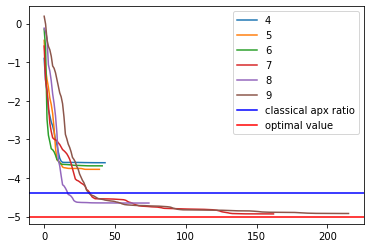

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(4,10,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-0.6261770496873996 -2.0133564320775665 -2.3606495163541057 -2.795838411181368 -3.262993629121712 -3.3349790253803646 -3.4590334696818537 -3.653043492576561 -3.7687936222099694 -3.9154604558710364 -3.9888496933969053 -4.010471490370738 -4.031070094145444 -4.065126917883615 -4.128148450668367 -4.166124351200789 -4.207474588121498 -4.249778465559927 -4.318498862256372 -4.381830975101282 -4.428130409636019 -4.47232377418382 -4.496835666686273 -4.518071381338943 -4.53554438388193 -4.555805245340927 -4.586359081130626 -4.613929868190911 -4.629123130774522 -4.652721016672261 -4.6706909073708855 -4.677503609968784 -4.680865719621137 -4.686029805781087 -4.694182588861584 -4.70479719648176 -4.716405526883535 -4.730555111179835 -4.736257182180367 -4.743401368655307 -4.7471399010216775 -4.750698354240532 -4.753689457650366 -4.755346197675221 -4.7558641784853455 -4.756694684661021 -4.758059145108308 -4.760186793431705 -4.763243258800959 -4.76664729505835 -4.771871365176666 -4.779676295062697 -4.79

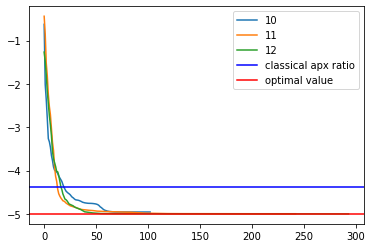

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(10,13,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

The optimization algorithm shows that for high numbers of levels, the computation time grows a lot, reaching 10 to 30 minutes. It also shows that the time until convergence is acknowledged increases a lot: this is why simulations for up to 9 layers and for 10 to 12 layers were separated into two distinct cells; so we could see the graphs.

The simulations show that if it suffices to reach the classical apx ratio as fast as possible, then the 8 layers case is the best. Though, for 7 to 12 layers there is not much difference in this regard. It can clearly be seen that 7 layers at least are required: up to 6 layers the simulation converges to a value far from the optimal one. 

In our simulation, surprisingly, the 8 layers case yields a result worse than the 7 layers one. I would then argue that, to ensure finding the closest possible result to the optimal value during a reasonable computation time, one should choose 9 or 10 layers.

### Question 6: smart initialization
One can rewrite the expression of $|\psi_{final}\rangle$ using the hypothesis that the exponential of the sum is equal to the product of the exponentials. Not forgetting that the factors do not necesarily commute, we get:
$$|\psi_{final}\rangle = e^{-i\int_0^T H(s) \text{d} s} |\psi_0\rangle$$
$$|\psi_{final}\rangle = \prod_{k=1}^p e^{-i(1-\frac k p) \sigma_x^k \frac T p} e^{-i\frac{kT}{p^2} H_C}|\psi_0\rangle$$

Here we recognize the expressions of the coefficients $\beta_k$ and $\theta_k$: $e^{-i\beta_k H_C} = e^{-i\frac{kT}{p^2}H_C}$ and $RX(\theta_k) = e^{-i\frac{\theta_k} 2 X} = e^{-i(1-\frac k p) \sigma_x^k \frac T p}$ from which we deduce:
$\beta_k = \frac{kT}{p^2}$ and $\theta_k = (1-\frac k p)\frac {2T} p$.

-1.0405715505168402 -1.5292954276981825 -1.9567108385017762 -3.963276100577071 -3.968420607250708 -3.975935176468193 -3.978042328390269 -3.9782499203275092 -3.9782688910945123 -3.978269025339624 -3.97826902959773 -3.9782690296559355 -0.5180161877983447 -1.7839330646231177 -3.0106922506674945 -3.170208207795462 -3.4666539479383283 -4.050282215427047 -4.193342767195923 -4.420928027565178 -4.553244482005365 -4.647187323056993 -4.652883714787907 -4.659906729479177 -4.661919292528216 -4.662441138246384 -4.662544665214668 -4.662579255904628 -4.662587688860361 -4.662589564966731 -4.662589588076014 -4.662589588288662 -0.8658690093077235 -1.2836836645212724 -1.8649633024736958 -2.09034531298824 -2.9367443714768626 -3.0662402957136625 -3.29086056863347 -3.717890161719934 -4.290960440536598 -4.37445409433623 -4.500485323640496 -4.624350844682501 -4.659931557501737 -4.710204239487717 -4.73397701211781 -4.739751304370875 -4.74499950295444 -4.750102340822735 -4.755804468199382 -4.764151196587207 -4.

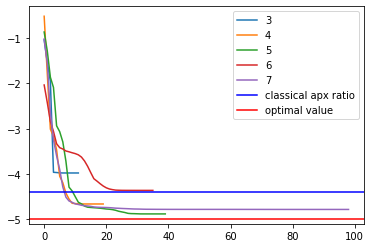

In [ ]:
T = 1.
import matplotlib.pyplot as plt

for nlayers in range(3,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []

    for k in range(1,nlayers+1):
      theta_k = (1-k/nlayers)*2*T/nlayers
      beta_k = k*T/nlayers
      parameters_init.append(theta_k)
      parameters_init.append(beta_k)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

Indeed, the simulations works surprisingly better with the right initial parameters! Only 4 layers are needed for the simulation to converge to an acceptable result, and in less than 10 seconds. The results become visually very convincing for 7 layers. In all cases the final result is closer to the optimal value than what was obtained before.

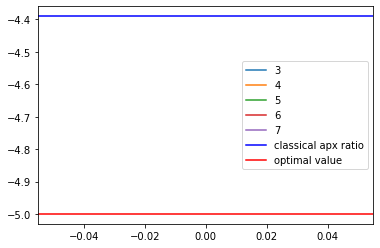

In [ ]:
T = 0.0000001

for nlayers in range(3,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []

    for k in range(1,nlayers+1):
      theta_k = (1-k/nlayers)*2*T/nlayers
      beta_k = k*T/nlayers
      parameters_init.append(theta_k)
      parameters_init.append(beta_k)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

Changing the value of T does not change significantly the convergence. One has to change it by several orders of magnitude to see the convergence's success decrease.